In [1]:
import numpy as np
import pandas as pd
import gym
from gym import Env
from gym.spaces import Box, Discrete, MultiDiscrete
import os
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Convolution2D
from tensorflow.keras.optimizers import Adam
import random
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import minimize

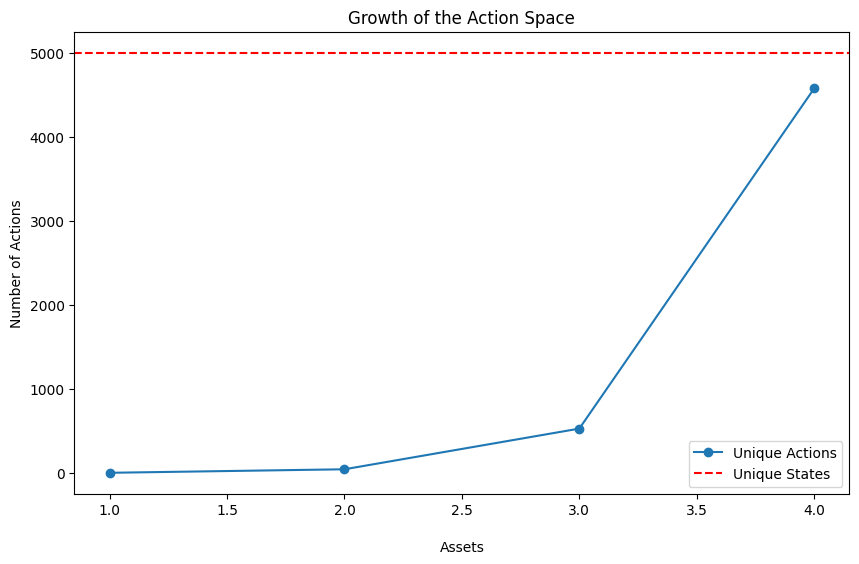

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import binom

# Define the function
def F(n, m):
    return 2**n * binom(m + n - 1, n - 1)

# Fixed value of m
m = 10

# Values of n to plot
m_values = np.arange(1, 5)

# Calculate the function values for each n
F_values = [F(n, m) for n in m_values]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(m_values, F_values, label=f'Unique Actions', marker='o')

# Add the horizontal line at 5000
plt.axhline(y=5000, color='r', linestyle='--', label='Unique States')

# Title and labels
plt.title('Growth of the Action Space')
plt.xlabel('Assets')
plt.ylabel('Number of Actions')

# Adjust the position of the x-axis label
plt.gca().xaxis.set_label_coords(0.5, -0.1)

# Legend
plt.legend()

# Save the figure
plt.savefig('Growth_of_the_Action_Space_asset.png')

# Display the plot
plt.show()


In [3]:
action = np.array([0,1,3,4])
[np.where(action[i] == 1)[0] for i in range(len(action))]

C:\Users\20213931\AppData\Local\Temp\ipykernel_14748\3070650944.py:2: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  [np.where(action[i] == 1)[0] for i in range(len(action))]


[array([], dtype=int64),
 array([0], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64)]

In [4]:

def tangency_weights(covariance_matrix, mean_vector):
    n = len(mean_vector)
    
    # Objective function to maximize (Sharpe ratio)
    def objective_function(weights):
        portfolio_return = np.dot(weights, mean_vector)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
        return -portfolio_return / portfolio_std
    
    # Constraint: sum of weights equals 1
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(np.abs(weights)) - 1})
    
    # Bounds for each weight (-1 <= weight <= 1)
    bounds = tuple((-1, 1) for _ in range(n))
    
    # Initial guess for weights
    initial_guess = np.ones(n) / n
    
    # Optimization
    result = minimize(objective_function, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    
    # Extracting optimal weights
    optimal_weights = result.x
    
    # Calculate the mean and standard deviation of the tangency portfolio
    tangency_return = np.dot(optimal_weights, mean_vector)
    tangency_std = np.sqrt(np.dot(optimal_weights.T, np.dot(covariance_matrix, optimal_weights)))
    
    return {
        'weights': optimal_weights,
        'mean': tangency_return,
        'std': tangency_std,
        'maximized_value': -result.fun  # Negative because we minimized the negative of Sharpe ratio
    }

# Example usage:
# Assuming RewardVector is a DataFrame containing your data
Cov= np.array([[ 8.18043490e-05,- 1.81927560e-05],[-1.81927560e-05,  2.84541162e-05]])
reward = np.array([8.42930239e-06 ,-9.12475773e-05])
result = tangency_weights(Cov, reward)
print("Optimal Weights:", result['weights'])
print("Tangency Portfolio Mean:", result['mean'] * 100)  # Assuming mean is annualized
print("Tangency Portfolio Standard Deviation:", result['std'])
print("Maximized Value:", result['maximized_value'])

Optimal Weights: [1.0000000e+00 6.9388939e-18]
Tangency Portfolio Mean: 0.0008429302389999999
Tangency Portfolio Standard Deviation: 0.009044575667216235
Maximized Value: 0.0009319732290541381


In [7]:
import pandas as pd

# Load the CSV files
import pandas as pd

# Load the data
IBM = pd.read_csv('IBM.csv')
KO = pd.read_csv('KO.csv')

# Select the last 260 data points and then remove the last 10
IBM = IBM.tail(260).iloc[:-10]
KO = KO.tail(260).iloc[:-10]




In [8]:
merged_df = pd.merge(KO, IBM, on='Date', suffixes=('_KO', '_IBM'))
columns_to_drop = ['Adj Close_KO', 'Volume_KO', 'Adj Close_IBM', 'Volume_IBM']
merged_df.drop(columns=columns_to_drop, inplace=True)
merged_df.drop(columns=['Date'], inplace=True) 
merged_df.rename(columns={
    'Open_KO': 'Stock_1_Open',
    'High_KO': 'Stock_1_High',
    'Low_KO': 'Stock_1_Low',
    'Close_KO': 'Stock_1_Close',
    'Open_IBM': 'Stock_2_Open',
    'High_IBM': 'Stock_2_High',
    'Low_IBM': 'Stock_2_Low',
    'Close_IBM': 'Stock_2_Close'
}, inplace=True)
merged_df.tail()

,Stock_1_Open,Stock_1_High,Stock_1_Low,Stock_1_Close,Stock_2_Open,Stock_2_High,Stock_2_Low,Stock_2_Close
245,59.349998,59.619999,58.959999,59.389999,186.630005,188.949997,185.949997,187.639999
246,59.599998,60.840000,59.509998,60.700001,187.639999,188.770004,183.059998,183.440002
247,60.990002,61.279999,60.830002,61.240002,182.559998,183.029999,178.750000,179.699997
248,60.990002,61.250000,60.500000,61.150002,182.449997,184.550003,181.929993,184.210007
249,61.090000,61.619999,61.000000,61.200001,184.899994,186.460007,184.570007,185.720001


In [9]:
def StandardizeData(data, n):
    if isinstance(data, pd.DataFrame):
        df = data.copy()  # Make a copy to avoid modifying the original DataFrame
    elif isinstance(data, list):
        df = pd.DataFrame(data)  # Convert list to DataFrame
    else:
        raise ValueError("Input data must be a DataFrame or a list.")
    
    Standardized = pd.DataFrame()
    for col in df.columns:
        ST = pd.DataFrame()
        for i in range(n+1):
            stock_num = int(col.split('_')[1])  # Extract the stock number from the column name
            close_col = f'Stock_{stock_num}_Close'  # Get the corresponding 'Close' column
            ST[f'{col}_{i}'] = df[col].shift(-i) / df[close_col].shift(-n)  # Divide by the corresponding 'Close' column
        Standardized = pd.concat([Standardized, ST], axis=1)
    
    # Drop rows with NaN values
    


    Ratio = pd.DataFrame()
    close_columns = [col for col in df.columns if 'Close' in col]
    for col in close_columns:
        
        Ratio[col] = np.log(df[col].shift(-n-1) /df[col].shift(-n) )
        Ratio.dropna()


    return Standardized[:-n-1], Ratio[:-n-1]

InputStates, RewardVector = StandardizeData(merged_df, 4)
print(RewardVector.iloc[:2529].cov() , RewardVector.iloc[:2529].mean())

               Stock_1_Close  Stock_2_Close
Stock_1_Close       0.000066       0.000017
Stock_2_Close       0.000017       0.000136 Stock_1_Close    0.000119
Stock_2_Close    0.001467
dtype: float64


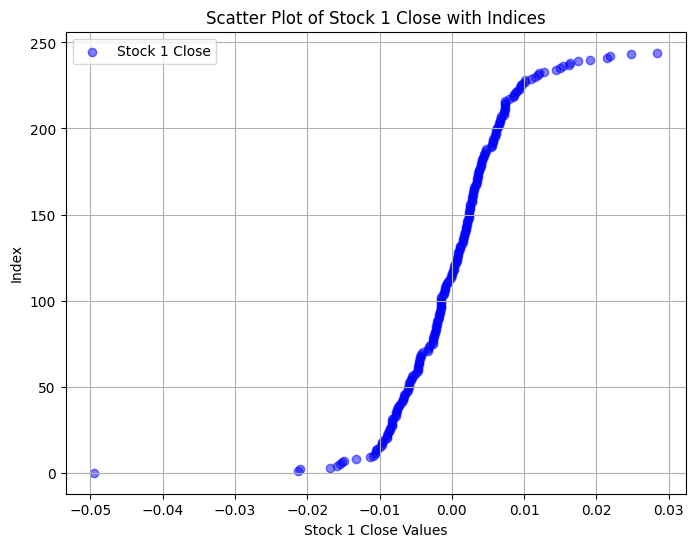

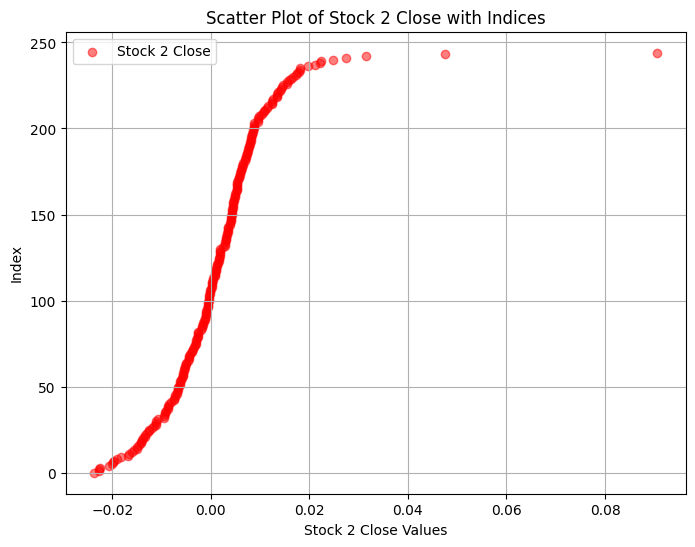

In [10]:
import matplotlib.pyplot as plt

# Sort the data by the 'Stock_1_Close' column
sorted_data_stock1 = RewardVector.sort_values(by='Stock_1_Close')
sorted_indices_stock1 = range(len(sorted_data_stock1))

# Create scatter plot for 'Stock_1_Close'
plt.figure(figsize=(8, 6))
plt.scatter(sorted_data_stock1['Stock_1_Close'], sorted_indices_stock1, color='blue', label='Stock 1 Close', alpha=0.5)
plt.title('Scatter Plot of Stock 1 Close with Indices')
plt.xlabel('Stock 1 Close Values')
plt.ylabel('Index')
plt.legend()
plt.grid(True)
plt.show()

# Sort the data by the 'Stock_2_Close' column
sorted_data_stock2 = RewardVector.sort_values(by='Stock_2_Close')
sorted_indices_stock2 = range(len(sorted_data_stock2))

# Create scatter plot for 'Stock_2_Close'
plt.figure(figsize=(8, 6))
plt.scatter(sorted_data_stock2['Stock_2_Close'], sorted_indices_stock2, color='red', label='Stock 2 Close', alpha=0.5)
plt.title('Scatter Plot of Stock 2 Close with Indices')
plt.xlabel('Stock 2 Close Values')
plt.ylabel('Index')
plt.legend()
plt.grid(True)
plt.show()




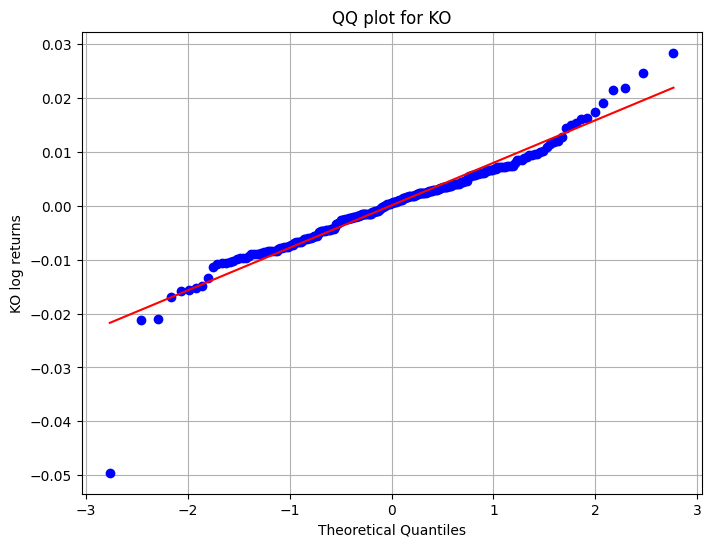

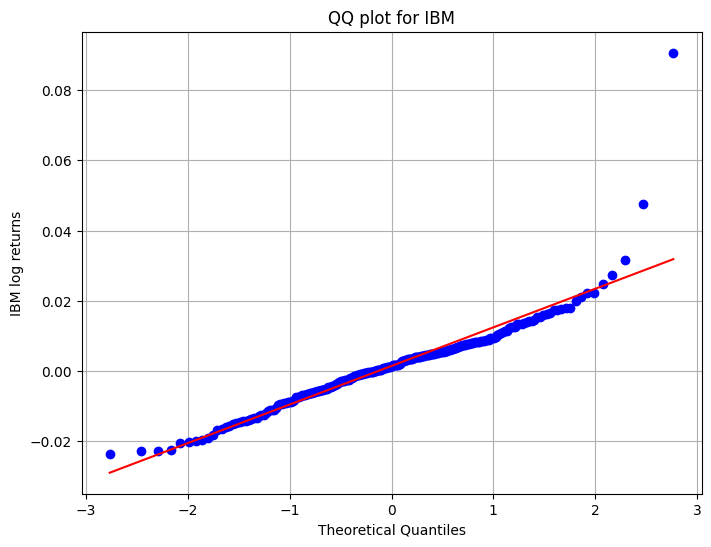

In [11]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Sort the data by the 'Stock_1_Close' column
sorted_data_stock1 = RewardVector.sort_values(by='Stock_1_Close')['Stock_1_Close']

# Create Q-Q plot for 'Stock_2_Close'
plt.figure(figsize=(8, 6))
stats.probplot(sorted_data_stock1, dist="norm", plot=plt)
plt.title('QQ plot for KO')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('KO log returns')
plt.grid(True)
plt.savefig('KOQQlast250.png')
plt.show()

# Sort the data by the 'Stock_2_Close' column
sorted_data_stock2 = RewardVector.sort_values(by='Stock_2_Close')['Stock_2_Close']

# Create Q-Q plot for 'Stock_2_Close'
plt.figure(figsize=(8, 6))
stats.probplot(sorted_data_stock2, dist="norm", plot=plt)
plt.title('QQ plot for IBM')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('IBM log returns')
plt.grid(True)
plt.savefig('IBMQQlast250.png')
plt.show()


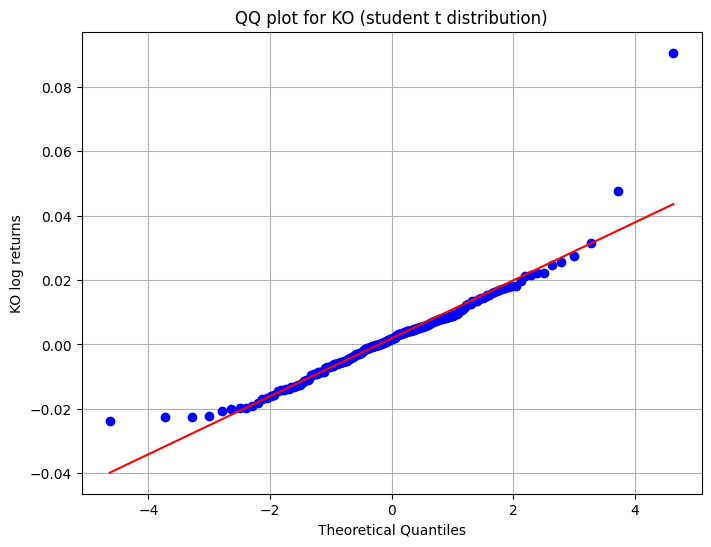

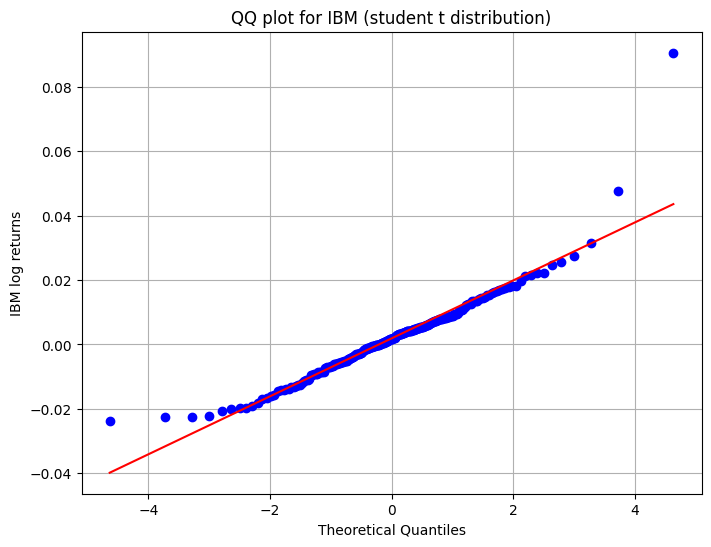

In [14]:
# Plot Q-Q plot for t-distribution
plt.figure(figsize=(8, 6))
stats.probplot(sorted_data_stock1, dist="t", sparams=(5,), plot=plt)
plt.title('QQ plot for KO (student t distribution)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('KO log returns')
plt.grid(True)
plt.savefig('KOQQstudentt.png')
plt.show()

# Plot Q-Q plot for t-distribution
plt.figure(figsize=(8, 6))
stats.probplot(sorted_data_stock2, dist="t", sparams=(5,), plot=plt)
plt.title('QQ plot for IBM (student t distribution)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('IBM log returns')
plt.grid(True)
plt.savefig('IBMQQstudentt.png')
plt.show()

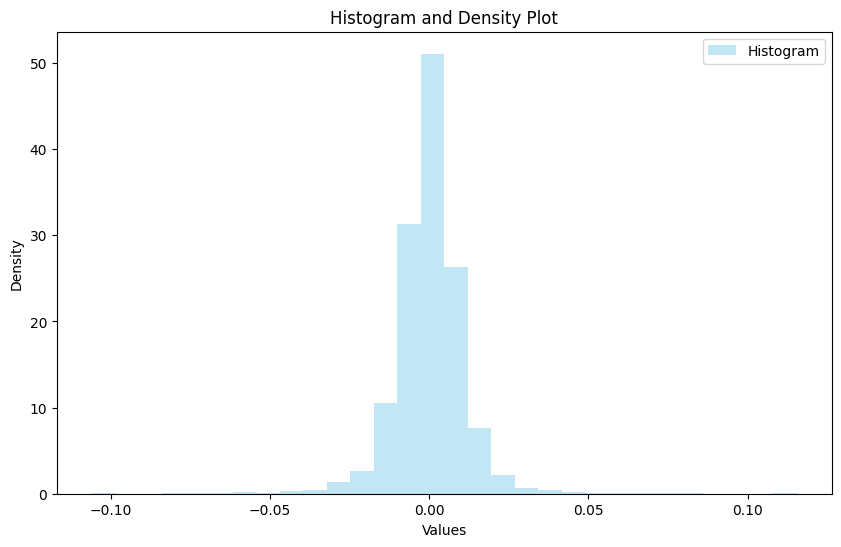

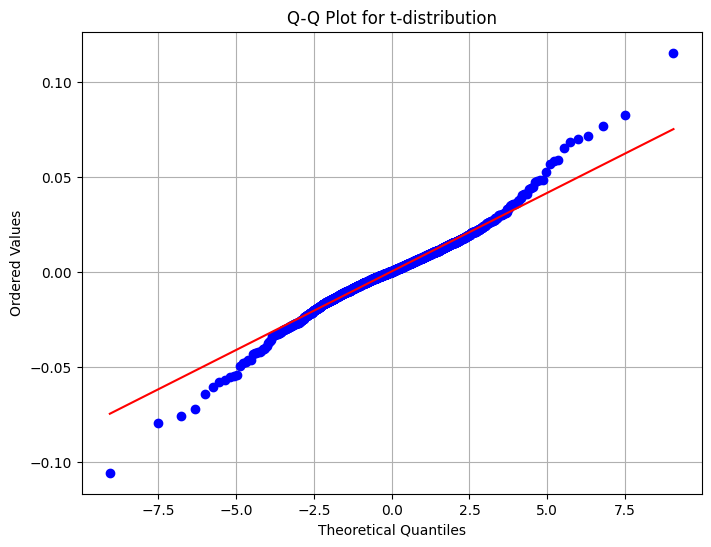

Kolmogorov-Smirnov Test - Statistic: 0.48130279303432355, p-value: 0.0
Kolmogorov-Smirnov Test (Cauchy) - Statistic: 0.48352439190663477, p-value: 0.0
Shapiro-Wilk Test - Statistic: 0.9032787084579468, p-value: 0.0


c:\Users\20213931\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [10]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt


# Plot histogram and density plot
plt.figure(figsize=(10, 6))
plt.hist(sorted_data_stock2, bins=30, density=True, alpha=0.5, color='skyblue', label='Histogram')
plt.title('Histogram and Density Plot')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()

# Plot Q-Q plot for t-distribution
plt.figure(figsize=(8, 6))
stats.probplot(sorted_data_stock2, dist="t", sparams=(5,), plot=plt)
plt.title('Q-Q Plot for t-distribution')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.grid(True)
plt.show()

# Perform Kolmogorov-Smirnov test for t-distribution
ks_statistic, ks_p_value = stats.kstest(sorted_data_stock2, 't', args=(5,))
print(f"Kolmogorov-Smirnov Test - Statistic: {ks_statistic}, p-value: {ks_p_value}")

# Perform Kolmogorov-Smirnov test for Cauchy distribution
ks_statistic_cauchy, ks_p_value_cauchy = stats.kstest(sorted_data_stock2, 'cauchy')
print(f"Kolmogorov-Smirnov Test (Cauchy) - Statistic: {ks_statistic_cauchy}, p-value: {ks_p_value_cauchy}")


# Perform Shapiro-Wilk test for normality
shapiro_statistic, shapiro_p_value = stats.shapiro(sorted_data_stock2)
print(f"Shapiro-Wilk Test - Statistic: {shapiro_statistic}, p-value: {shapiro_p_value}")


In [11]:
ks_statistic_lognormal, ks_p_value_lognormal = stats.kstest(sorted_data_stock1, 'lognorm', args=(1,))
print(f"Kolmogorov-Smirnov Test (Lognormal) - Statistic: {ks_statistic_lognormal}, p-value: {ks_p_value_lognormal}")

Kolmogorov-Smirnov Test (Lognormal) - Statistic: 0.9965824759070131, p-value: 0.0


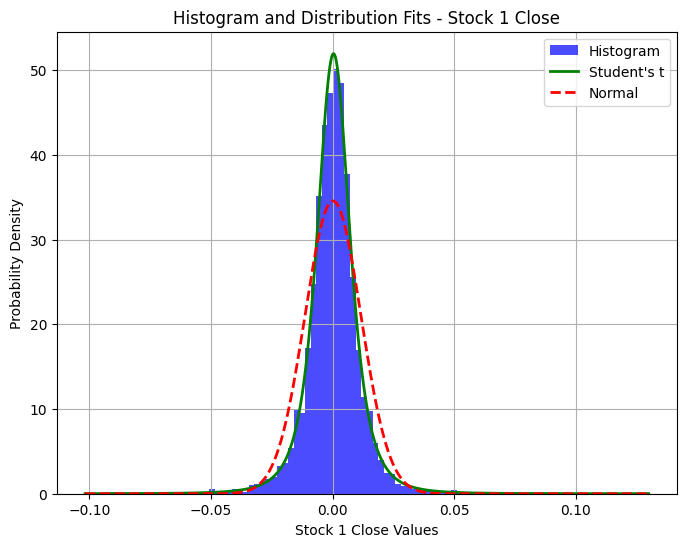

In [12]:
import numpy as np
from scipy.stats import t, norm
import matplotlib.pyplot as plt

# Fit Student's t distribution to data
params_t = t.fit(RewardVector['Stock_1_Close'])

# Fit normal distribution to data
mu, sigma = norm.fit(RewardVector['Stock_1_Close'])

# Generate x values for PDFs
x = np.linspace(min(RewardVector['Stock_1_Close']), max(RewardVector['Stock_1_Close']), 1000)

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(RewardVector['Stock_1_Close'], bins=100, color='blue', alpha=0.7, density=True, label='Histogram')

# Overlay Student's t distribution
plt.plot(x, t.pdf(x, *params_t[:-2], loc=params_t[-2], scale=params_t[-1]), color='green', linestyle='-', linewidth=2, label='Student\'s t')

# Overlay normal distribution
plt.plot(x, norm.pdf(x, mu, sigma), color='red', linestyle='--', linewidth=2, label='Normal')

plt.title('Histogram and Distribution Fits - Stock 1 Close')
plt.xlabel('Stock 1 Close Values')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.savefig('hist.png')
plt.show()


NameError: name 'area' is not defined

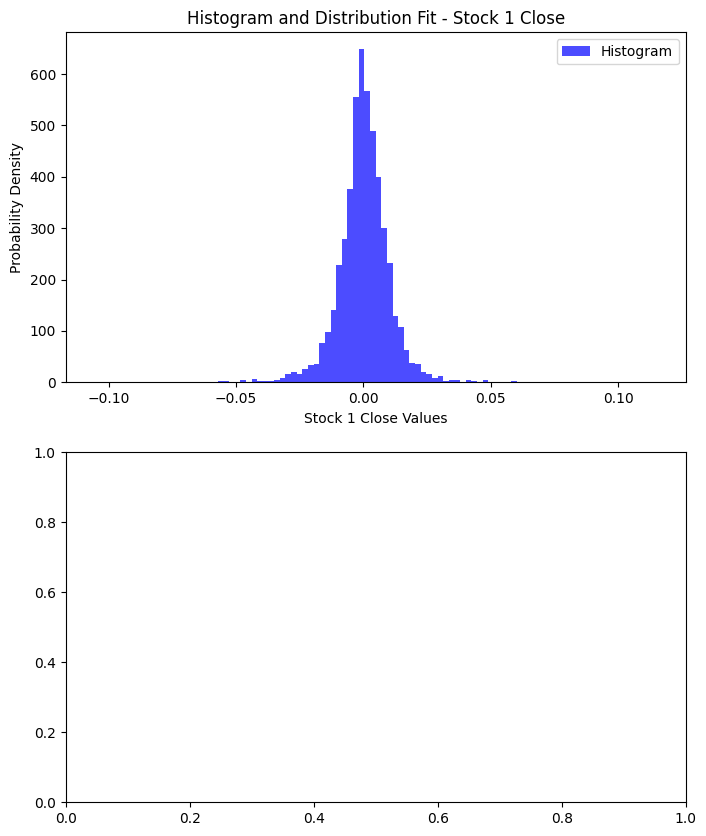

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from scipy.stats import gaussian_kde

# Fit Student's t distribution to data
params_t = t.fit(RewardVector['Stock_2_Close'])

# Generate x values for PDFs
x = np.linspace(min(RewardVector['Stock_2_Close']), max(RewardVector['Stock_2_Close']), 1000)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot histogram
hist, bins, _ = ax1.hist(RewardVector['Stock_2_Close'], bins=100, color='blue', alpha=0.7, label='Histogram')

# Calculate area under histogram


# Normalize histogram


ax1.set_title('Histogram and Distribution Fit - Stock 1 Close')
ax1.set_xlabel('Stock 1 Close Values')
ax1.set_ylabel('Probability Density')
ax1.legend()

# Plot density plot
ax2.bar(bins[:-1], hist / area, width=np.diff(bins), color='blue', alpha=0.7, label='Density Plot')

# Overlay Student's t distribution on histogram
ax2.plot(x, t.pdf(x, *params_t[:-2], loc=params_t[-2], scale=params_t[-1]), color='green', linestyle='-', linewidth=2, label='Student\'s t')

ax2.set_title('Density Plot and Distribution Fit - Stock 1 Close')
ax2.set_xlabel('Stock 1 Close Values')
ax2.set_ylabel('Probability Density')
ax2.legend()

plt.tight_layout()
plt.show()





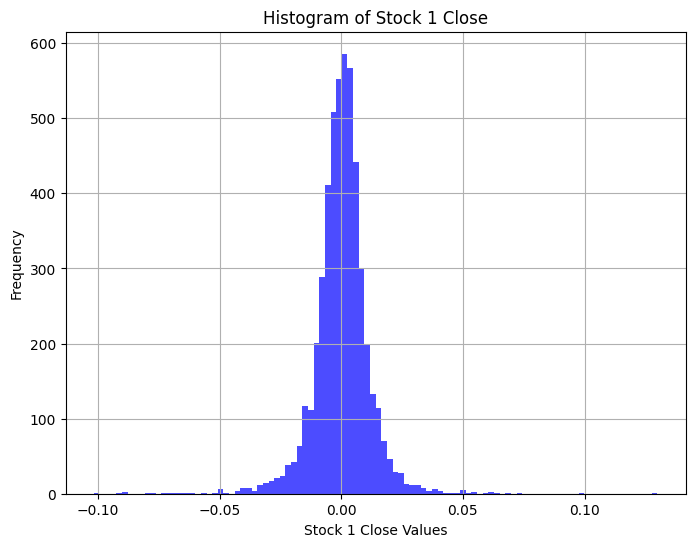

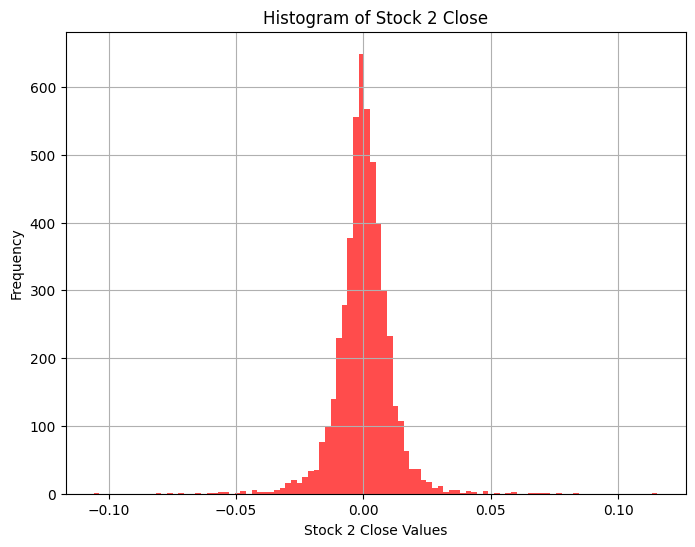

In [14]:
import matplotlib.pyplot as plt

# Histogram for 'Stock_1_Close'
plt.figure(figsize=(8, 6))
plt.hist(RewardVector['Stock_1_Close'], bins=100, color='blue', alpha=0.7)
plt.title('Histogram of Stock 1 Close')
plt.xlabel('Stock 1 Close Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Histogram for 'Stock_2_Close'
plt.figure(figsize=(8, 6))
plt.hist(RewardVector['Stock_2_Close'], bins=100, color='red', alpha=0.7)
plt.title('Histogram of Stock 2 Close')
plt.xlabel('Stock 2 Close Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [15]:
from scipy.stats import shapiro

# Perform Shapiro-Wilk test for 'Stock_1_Close'
stat_stock1, p_stock1 = shapiro(RewardVector['Stock_1_Close'])
print("Shapiro-Wilk test for Stock 1 Close:")
print("Test Statistic:", stat_stock1)
print("p-value:", p_stock1)
if p_stock1 > 0.05:
    print("The data for Stock 1 Close follows a normal distribution")
else:
    print("The data for Stock 1 Close does not follow a normal distribution")

# Perform Shapiro-Wilk test for 'Stock_2_Close'
stat_stock2, p_stock2 = shapiro(RewardVector['Stock_2_Close'])
print("\nShapiro-Wilk test for Stock 2 Close:")
print("Test Statistic:", stat_stock2)
print("p-value:", p_stock2)
if p_stock2 > 0.05:
    print("The data for Stock 2 Close follows a normal distribution")
else:
    print("The data for Stock 2 Close does not follow a normal distribution")


Shapiro-Wilk test for Stock 1 Close:
Test Statistic: 0.8951433300971985
p-value: 0.0
The data for Stock 1 Close does not follow a normal distribution

Shapiro-Wilk test for Stock 2 Close:
Test Statistic: 0.9032787084579468
p-value: 0.0
The data for Stock 2 Close does not follow a normal distribution


In [16]:
import pandas as pd
from statsmodels.stats.stattools import durbin_watson

# Example data series (replace this with your actual data)
data_series = RewardVector['Stock_1_Close']

# Runs Test
durbin_watson(data_series)



2.093612622008162

In [4]:
import warnings
warnings.simplefilter('ignore')
from prophet import Prophet
KO = pd.read_csv('KO.csv')

Importing plotly failed. Interactive plots will not work.


In [5]:
data = pd.read_excel('data.xlsx')
data.drop(['Stock_1_Open', 'Stock_1_High', 'Stock_1_Low','Stock_2_Open', 'Stock_2_High', 'Stock_2_Low','Stock_1_Close' ], axis = 1 , inplace = True)
data.columns=['y']

data

,y
0,0.989975
1,0.982156
2,0.990102
3,0.992789
4,0.992108
...,...
5035,1.379320
5036,1.377166
5037,1.386624
5038,1.386879


In [6]:
KO.drop(['Open', 'High', 'Low','Adj Close', 'Volume'], axis = 1 , inplace = True)

KO.columns = [ 'ds', 'y']
KO

,ds,y
0,2004-02-10,26.084999
1,2004-02-11,25.900000
2,2004-02-12,25.770000
3,2004-02-13,25.570000
4,2004-02-17,25.570000
...,...,...
5049,2024-03-04,59.810001
5050,2024-03-05,59.520000
5051,2024-03-06,59.549999
5052,2024-03-07,59.439999


In [7]:
data['ds'] = KO['ds']
data.dropna
data.tail()

,y,ds
5035,1.379320,2024-02-12
5036,1.377166,2024-02-13
5037,1.386624,2024-02-14
5038,1.386879,2024-02-15
5039,1.377007,2024-02-16


In [23]:
m= Prophet()
model = m.fit(KO)

15:58:01 - cmdstanpy - INFO - Chain [1] start processing
15:58:03 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
future = m.make_future_dataframe(periods=100 , freq='D')
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
5149,2024-06-12,63.983932,61.166306,66.814640,63.901127,64.044460,-0.023530,-0.023530,-0.023530,-0.149376,-0.149376,-0.149376,0.125847,0.125847,0.125847,0.0,0.0,0.0,63.960402
5150,2024-06-13,63.992180,61.018241,66.516203,63.907660,64.055042,-0.059929,-0.059929,-0.059929,-0.157770,-0.157770,-0.157770,0.097841,0.097841,0.097841,0.0,0.0,0.0,63.932251
5151,2024-06-14,64.000428,60.846572,66.665386,63.914018,64.064184,-0.082996,-0.082996,-0.082996,-0.152810,-0.152810,-0.152810,0.069814,0.069814,0.069814,0.0,0.0,0.0,63.917432
5152,2024-06-15,64.008675,61.886722,67.263008,63.919529,64.073326,0.418574,0.418574,0.418574,0.376476,0.376476,0.376476,0.042098,0.042098,0.042098,0.0,0.0,0.0,64.427250
5153,2024-06-16,64.016923,61.695730,67.299726,63.925805,64.082468,0.391502,0.391502,0.391502,0.376476,0.376476,0.376476,0.015026,0.015026,0.015026,0.0,0.0,0.0,64.408425


In [25]:

import pandas as pd
import numpy as np
import statsmodels.api as sm

# Fit Prophet model
m = Prophet()
model = m.fit(data)

# Make future dataframe
future = m.make_future_dataframe(periods=100, freq='D')

# Generate forecasts
forecast = m.predict(future)

# Extract trend component
trend_component = forecast['trend']

# Statistical tests for trends

# Linear regression analysis
X = sm.add_constant(np.arange(len(trend_component)))
model = sm.OLS(trend_component, X)
results = model.fit()
print("Linear Regression p-value:", results.pvalues[1])

# Autocorrelation analysis
autocorrelation = sm.tsa.acf(trend_component)
print("Autocorrelation:", autocorrelation)

# Validation (if needed)

# Visualization and interpretation
# Visualize trend component and results of statistical tests


15:58:06 - cmdstanpy - INFO - Chain [1] start processing
15:58:09 - cmdstanpy - INFO - Chain [1] done processing


Linear Regression p-value: 0.0
Autocorrelation: [1.         0.99940823 0.99881038 0.99820651 0.99759659 0.99698285
 0.99636055 0.99573226 0.99509803 0.99445972 0.99381439 0.99316108
 0.99250188 0.99183682 0.99116765 0.99049125 0.98980742 0.98911779
 0.98842235 0.98772284 0.9870159  0.98630207 0.98558253 0.98485724
 0.98412785 0.98339098 0.98264764 0.98189872 0.98114404 0.98038516
 0.97961901 0.97884669 0.97806889 0.97728533 0.97649753 0.97570262
 0.97490186 0.97409569]


In [26]:
forecast[['ds' , 'yhat']]

,ds,yhat
0,2004-02-10,0.984882
1,2004-02-11,0.985495
2,2004-02-12,0.986753
3,2004-02-13,0.987421
4,2004-02-17,0.990115
...,...,...
5135,2024-05-22,1.400710
5136,2024-05-23,1.400703
5137,2024-05-24,1.400098
5138,2024-05-25,1.402754


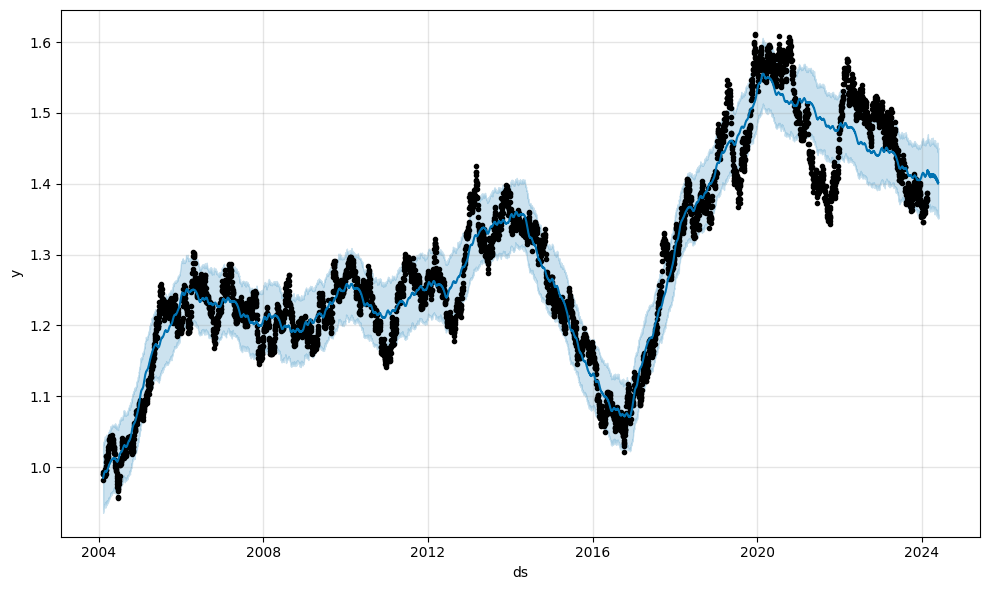

In [27]:
plot1 = m.plot(forecast)

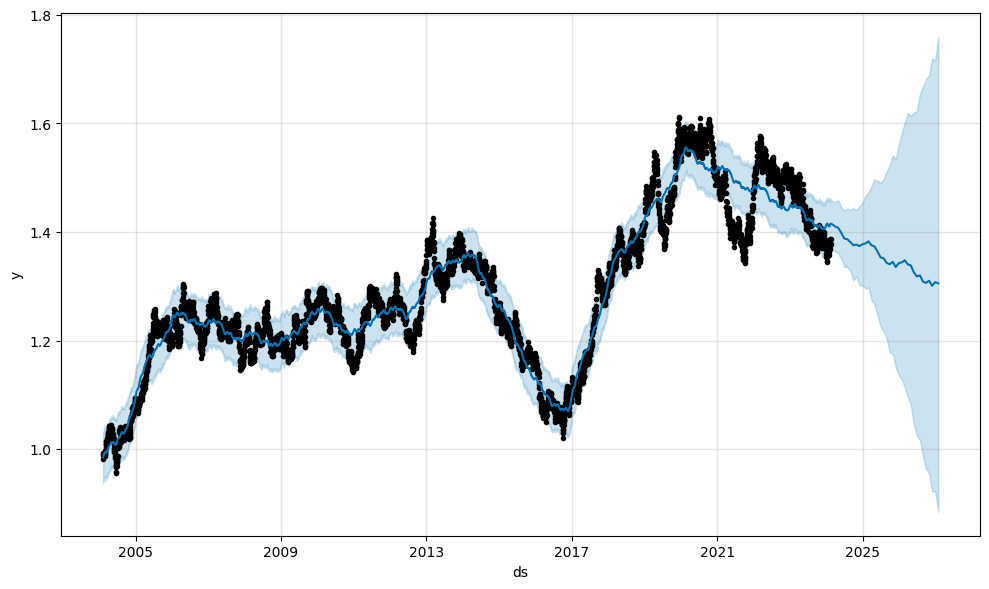

In [28]:
future_dates = m.make_future_dataframe(periods=36, freq='MS')
future_dates.head()
forecast =m.predict(future_dates)
plot1 = m.plot(forecast, uncertainty=True)

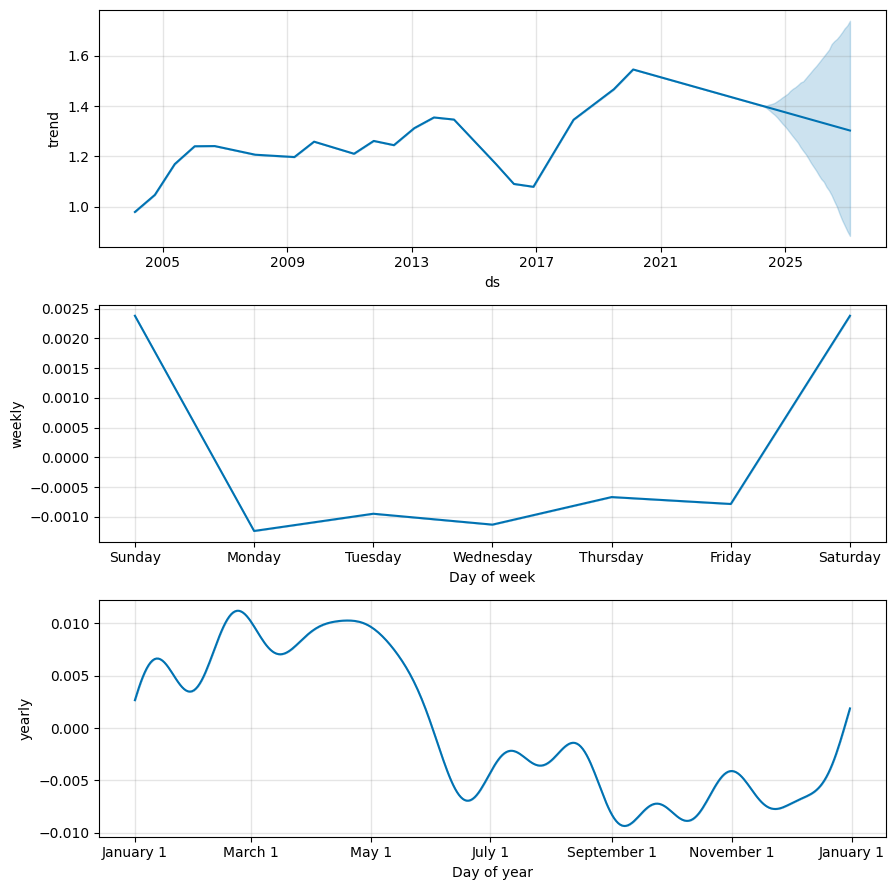

In [29]:
plot2 = m.plot_components(forecast)

In [48]:
m= Prophet(yearly_seasonality=True , weekly_seasonality=False)
model = m.fit(KO)

forecast = m.predict(future)
forecast.tail()

14:56:48 - cmdstanpy - INFO - Chain [1] start processing
14:56:50 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
5149,2024-06-12,63.940439,60.923461,66.575833,63.894215,64.007416,-0.120389,-0.120389,-0.120389,-0.120389,-0.120389,-0.120389,0.0,0.0,0.0,63.820049
5150,2024-06-13,63.948680,60.716535,66.702054,63.898394,64.018572,-0.133292,-0.133292,-0.133292,-0.133292,-0.133292,-0.133292,0.0,0.0,0.0,63.815388
5151,2024-06-14,63.956920,60.886117,66.692635,63.903276,64.030201,-0.127223,-0.127223,-0.127223,-0.127223,-0.127223,-0.127223,0.0,0.0,0.0,63.829697
5152,2024-06-15,63.965161,61.524116,67.043362,63.910135,64.041472,0.313546,0.313546,0.313546,0.313546,0.313546,0.313546,0.0,0.0,0.0,64.278707
5153,2024-06-16,63.973402,61.182370,67.158204,63.916993,64.051547,0.313546,0.313546,0.313546,0.313546,0.313546,0.313546,0.0,0.0,0.0,64.286948


In [ ]:
IBM.drop(['Open', 'High', 'Low','Adj Close', 'Volume'], axis = 1 , inplace = True)

IBM.columns = [ 'ds', 'y']

09:14:13 - cmdstanpy - INFO - Chain [1] start processing
09:14:15 - cmdstanpy - INFO - Chain [1] done processing


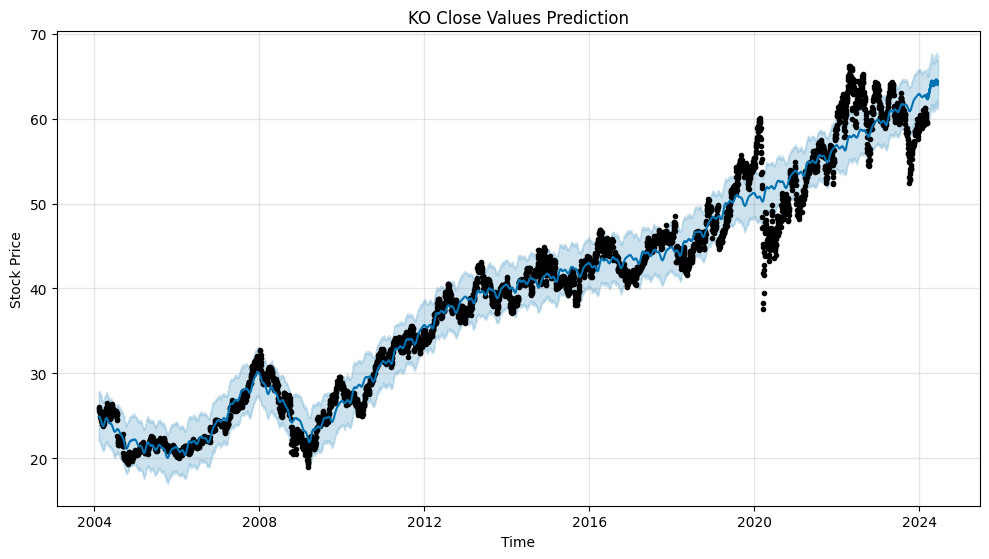

In [66]:
import matplotlib.pyplot as plt


# Fit the model
m = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model = m.fit(KO)

# Predict the future
forecast = m.predict(future)

# Plot the forecast
plot1 = m.plot(forecast, uncertainty=True)

# Customize the plot
plt.title('KO Close Values Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.grid(True)

# Adjust layout to prevent title from being cut off
plt.tight_layout(rect=[0, 0, 1, 0.95])  # This makes room for the title

# Get the axis and the lines
ax = plot1.gca()
lines = ax.get_lines()

# Customize the data and forecast lines
for line in lines:
    # Set color of the data points to black
    if line.get_label() == 'y':
        line.set_color('black')
    # Set color of the forecast to blue
    elif line.get_label() == 'yhat':
        line.set_color('blue')

# Show the plot
plt.savefig('KOpred.png')
plt.show()


In [31]:
future_dates = m.make_future_dataframe(periods=36, freq='MS')
future_dates.head()


,ds
0,2004-02-10
1,2004-02-11
2,2004-02-12
3,2004-02-13
4,2004-02-17


In [32]:
from scipy.stats import ttest_1samp

# Extract weekly seasonality component
weekly_seasonality = forecast['weekly']

# Perform t-test
t_statistic, p_value = ttest_1samp(weekly_seasonality, 0)
if p_value < 0.05:
    print('H1 weekly seasonality is significant.')
else:
    print('H0 weekly seasonality is not significant.')
print("Weekly Seasonality p-value:", p_value, t_statistic)


# Extract weekly seasonality component
weekly_seasonality = forecast['yearly']

# Perform t-test
t_statistic, p_value = ttest_1samp(weekly_seasonality, 0)
if p_value < 0.05:
    print('H1 yearly seasonality is significant.')
else:
    print('H0 yearly seasonality is not significant.')
print("Weekly Seasonality p-value:", p_value, t_statistic)

H1 weekly seasonality is significant.
Weekly Seasonality p-value: 0.0 -258.5926960461924
H0 yearly seasonality is not significant.
Weekly Seasonality p-value: 0.4264780630761211 -0.7952958398172912


In [18]:
from scipy.stats import ttest_1samp

# Extract weekly seasonality component
weekly_seasonality = forecast['yearly']

# Perform t-test
t_statistic, p_value = ttest_1samp(weekly_seasonality, 0)

# Degrees of freedom
degrees_of_freedom = len(weekly_seasonality) - 1

# Significance level
alpha = 0.05

# Rejection zone (two-tailed test)
critical_value = t.ppf(1 - alpha / 2, df=degrees_of_freedom)

# Print results
if p_value < alpha:
    print('H1: Weekly seasonality is significant.')
else:
    print('H0: Weekly seasonality is not significant.')
print("Weekly Seasonality p-value:", p_value)
print("T-statistic:", t_statistic)
print("Degrees of freedom:", degrees_of_freedom)
print("Rejection zone (two-tailed): T < -{:.4f} or T > {:.4f}".format(critical_value, critical_value))


NameError: name 't' is not defined

In [19]:
forecast =m.predict(future_dates)

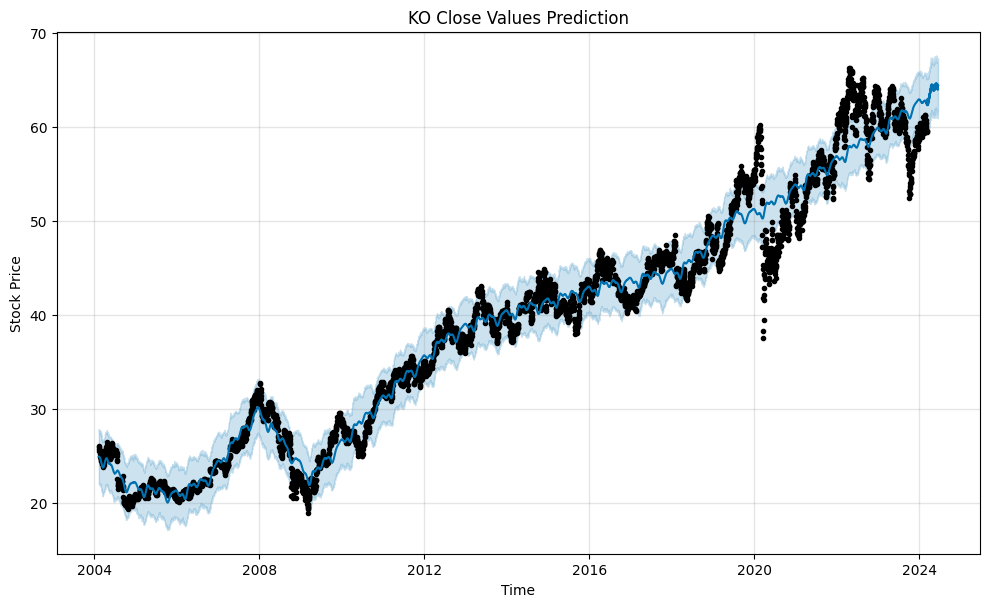

In [42]:
import matplotlib.pyplot as plt

# Plot the forecast
plot1 = m.plot(forecast, uncertainty=True)

# Customize the plot
plt.title('KO Close Values Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.grid(True)

# Get the axis and the lines
ax = plot1.gca()
lines = ax.get_lines()

# Customize the data and forecast lines
for line in lines:
    # Set color of the data points to black
    if line.get_label() == 'y':
        line.set_color('black')
    # Set color of the forecast to blue
    elif line.get_label() == 'yhat':
        line.set_color('blue')

# Show the plot
plt.savefig('KOpred.png')
plt.show()


In [ ]:
m.cros

16:06:10 - cmdstanpy - INFO - Chain [1] start processing
16:06:12 - cmdstanpy - INFO - Chain [1] done processing


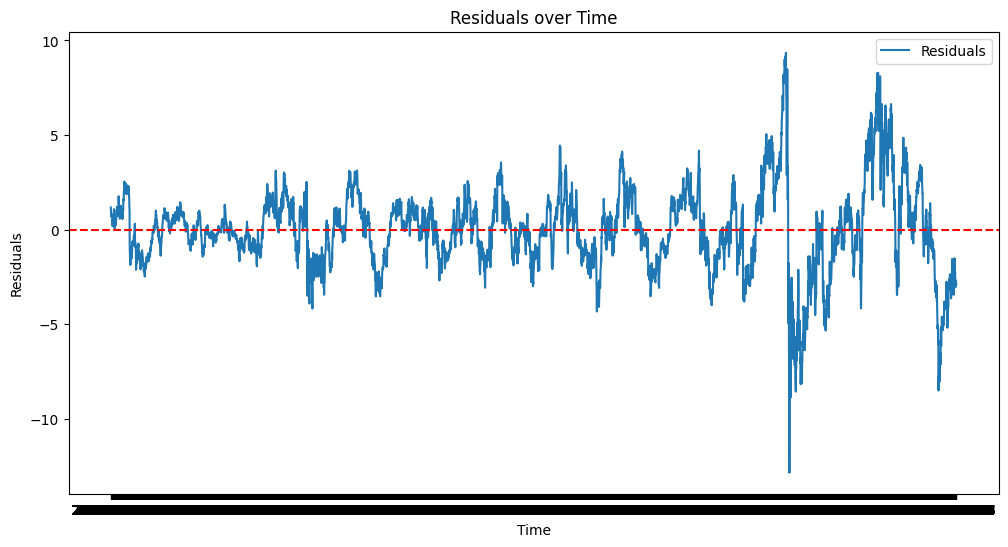

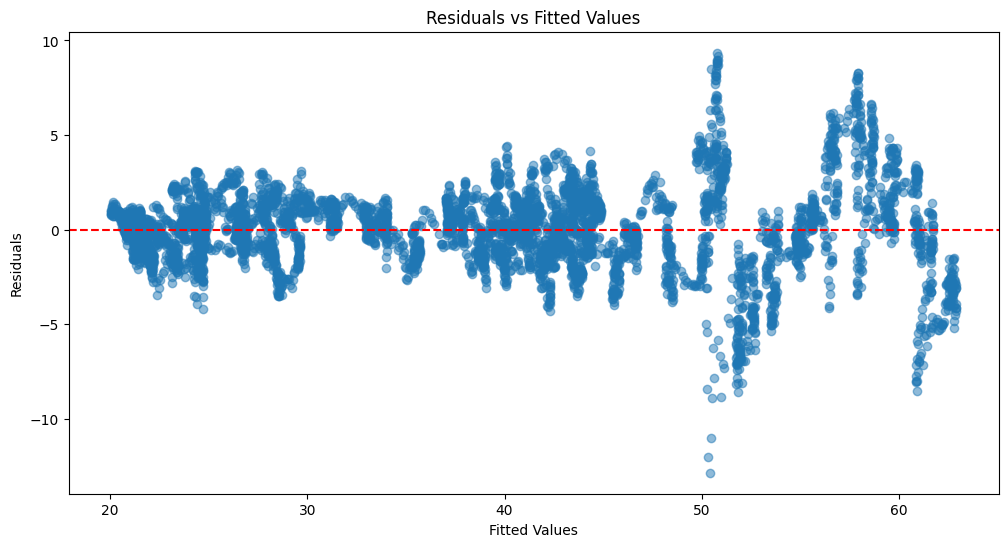

<Figure size 600x600 with 0 Axes>

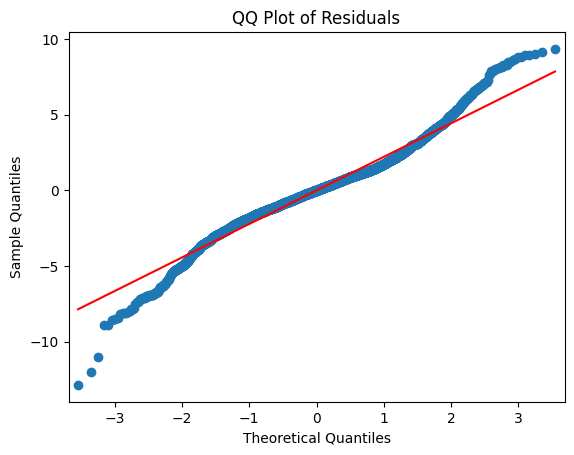

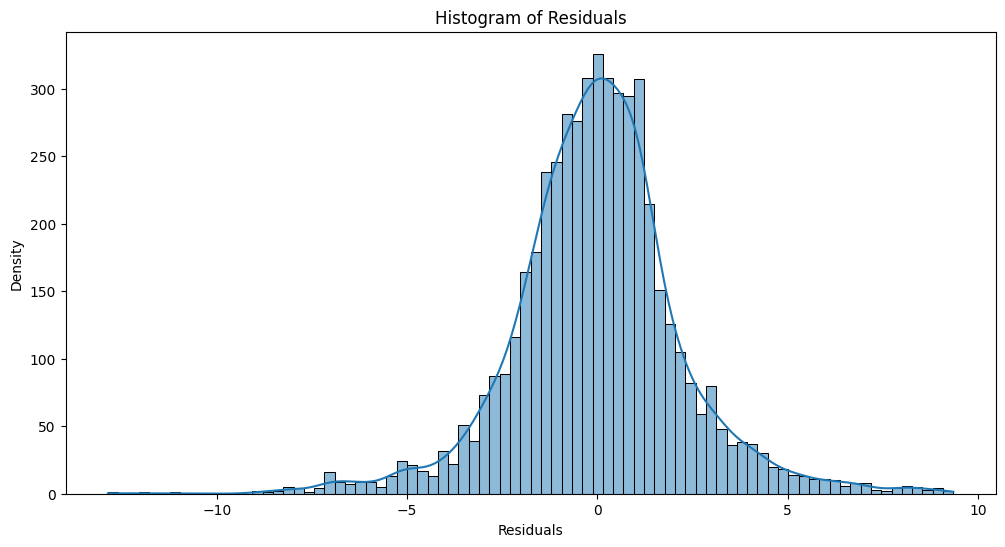

         lb_stat  lb_pvalue
10  40789.394626        0.0


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import acorr_ljungbox
import seaborn as sns

# Fit the Prophet model
m = Prophet()
model = m.fit(KO)
future = m.make_future_dataframe(periods=100, freq='D')
forecast = m.predict(future)

# Calculate residuals
KO['yhat'] = forecast['yhat'].iloc[:len(KO)]
KO['residuals'] = KO['y'] - KO['yhat']

# 1. Plot residuals over time (check for independence and homoscedasticity)
plt.figure(figsize=(12, 6))
plt.plot(KO['ds'], KO['residuals'], label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals over Time')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# 2. Residuals vs Fitted values plot (check for homoscedasticity)
plt.figure(figsize=(12, 6))
plt.scatter(KO['yhat'], KO['residuals'], alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# 3. QQ Plot (check for normality)
plt.figure(figsize=(6, 6))
qqplot(KO['residuals'], line='s')
plt.title('QQ Plot of Residuals')
plt.show()

# 4. Histogram of residuals (check for normality)
plt.figure(figsize=(12, 6))
sns.histplot(KO['residuals'], kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# 5. Breusch-Pagan test for homoscedasticity


# 6. Ljung-Box test for independence
lb_test = acorr_ljungbox(KO['residuals'], lags=[10], return_df=True)
print(lb_test)


In [37]:
KO

,ds,y,yhat,residuals
0,2004-02-10,26.084999,24.918412,1.166587
1,2004-02-11,25.900000,24.900559,0.999441
2,2004-02-12,25.770000,24.887287,0.882713
3,2004-02-13,25.570000,24.886125,0.683875
4,2004-02-17,25.570000,24.860026,0.709974
...,...,...,...,...
5049,2024-03-04,59.810001,62.485531,-2.675530
5050,2024-03-05,59.520000,62.476593,-2.956593
5051,2024-03-06,59.549999,62.432588,-2.882589
5052,2024-03-07,59.439999,62.395373,-2.955374


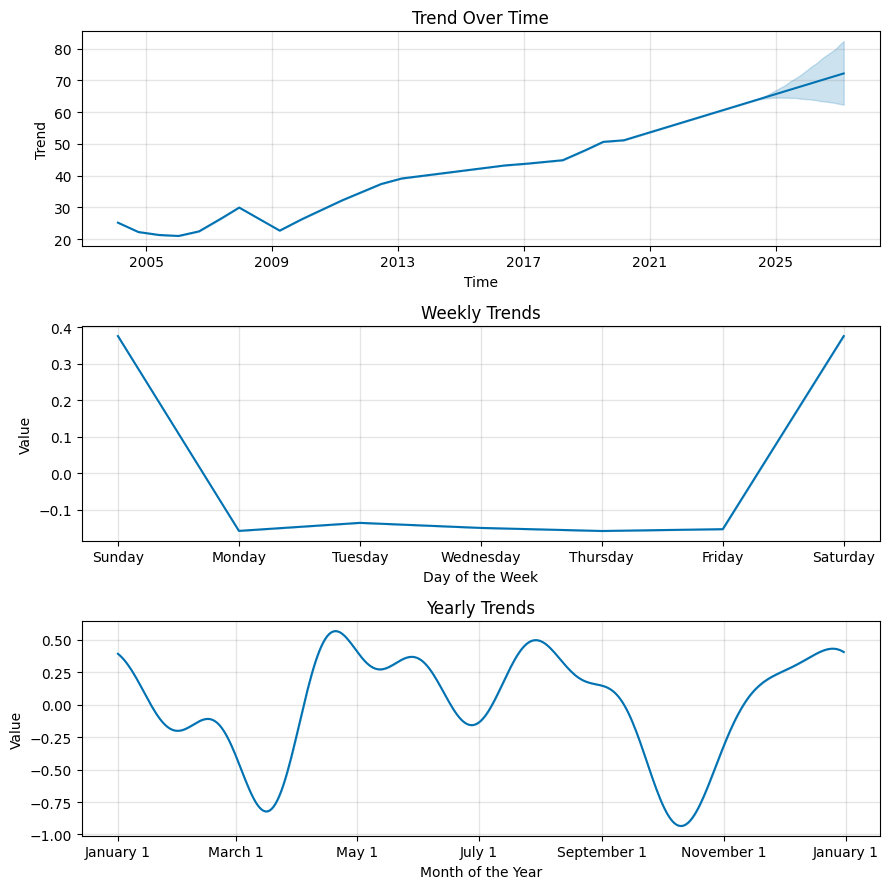

In [21]:
import matplotlib.pyplot as plt

# Plot components
plot2 = m.plot_components(forecast)

# Customize first subplot (trend over time)
ax1 = plot2.axes[0]
ax1.set_xlabel('Time')
ax1.set_ylabel('Trend')
ax1.set_title('Trend Over Time')

# Customize second subplot (weekly trends)
ax2 = plot2.axes[1]
ax2.set_xlabel('Day of the Week')
ax2.set_ylabel('Value')
ax2.set_title('Weekly Trends')

# Customize third subplot (yearly trends)
ax3 = plot2.axes[2]
ax3.set_xlabel('Month of the Year')
ax3.set_ylabel('Value')
ax3.set_title('Yearly Trends')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('trendsko.png')
# Show the plot
plt.show()


In [22]:
import pandas as pd
from statsmodels.stats.stattools import durbin_watson

# Example data series (replace this with your actual data)
data_series = (RewardVector['Stock_1_Close'])

# Shift the data by 20 rows to get the data from 20 rows ago
for i in range(1,20):
    lagged_data = data_series.shift(i)

    # Drop rows with NaN values introduced by shifting
    lagged_data = lagged_data.dropna()

    # Compute the Durbin-Watson statistic for the lagged data
    dw_statistic = durbin_watson(lagged_data)

    print("Durbin-Watson Statistic for lag:", i,  dw_statistic)


NameError: name 'RewardVector' is not defined

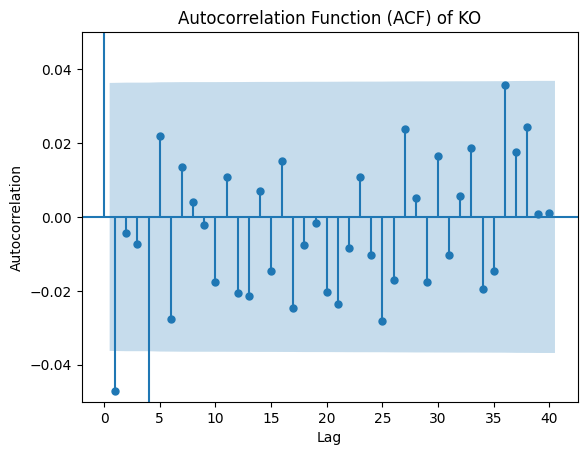

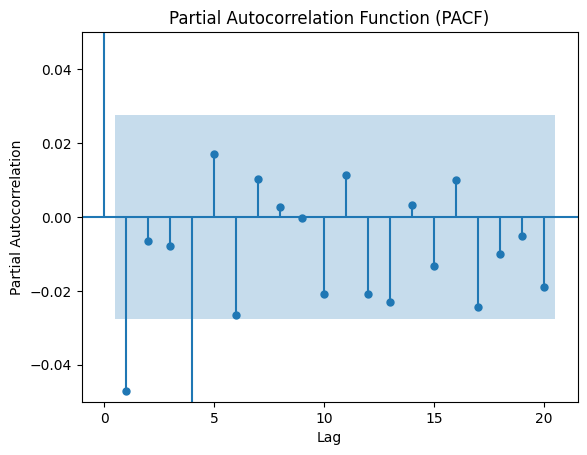

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Example data series (replace this with your actual data)
data_series = (RewardVector['Stock_1_Close'])

# Plot the Autocorrelation Function (ACF)
acf_fig = plot_acf(data_series, lags=40, alpha =0.01)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) of KO')
acf_fig.axes[0].set_ylim(-0.05, 0.05)  # Set y-axis limits
plt.savefig('acfko.png')
plt.show()

# Plot the Partial Autocorrelation Function (PACF)
pacf_fig = plot_pacf(data_series, lags=20)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
pacf_fig.axes[0].set_ylim(-0.05, 0.05)  # Set y-axis limits
plt.show()



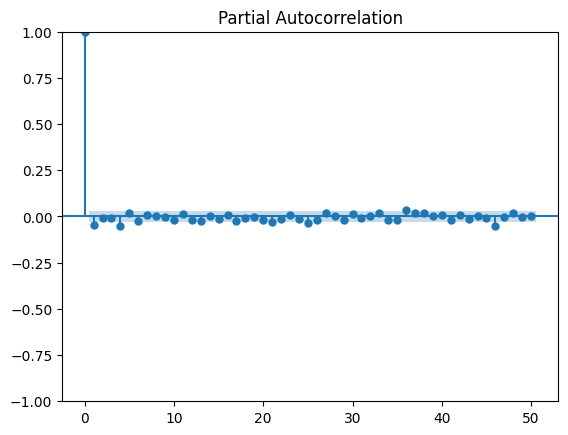

In [18]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf
series = (RewardVector['Stock_1_Close'])
plot_pacf(series, lags=50)
pyplot.show()

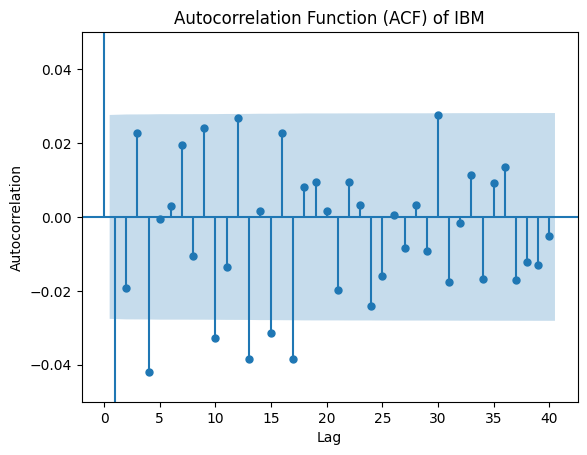

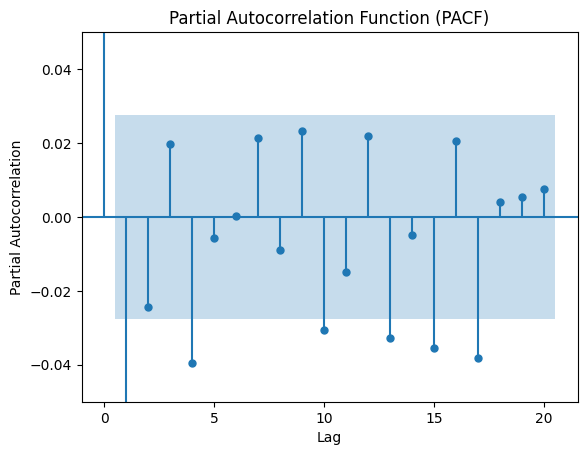

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Example data series (replace this with your actual data)
data_series = (RewardVector['Stock_2_Close'])

# Plot the Autocorrelation Function (ACF)
acf_fig = plot_acf(data_series, lags=40)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) of IBM')
acf_fig.axes[0].set_ylim(-0.05, 0.05)  # Set y-axis limits
plt.savefig('acfIBM.png')
plt.show()

# Plot the Partial Autocorrelation Function (PACF)
pacf_fig = plot_pacf(data_series, lags=20)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
pacf_fig.axes[0].set_ylim(-0.05, 0.05)  # Set y-axis limits
plt.show()


In [20]:
import statsmodels.api as sm
data_series = (RewardVector['Stock_2_Close'])
sm.stats.acorr_ljungbox(data_series, lags=[1], return_df=False)

,lb_stat,lb_pvalue
1,25.772782,3.840666e-07


c:\Users\20213931\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\20213931\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


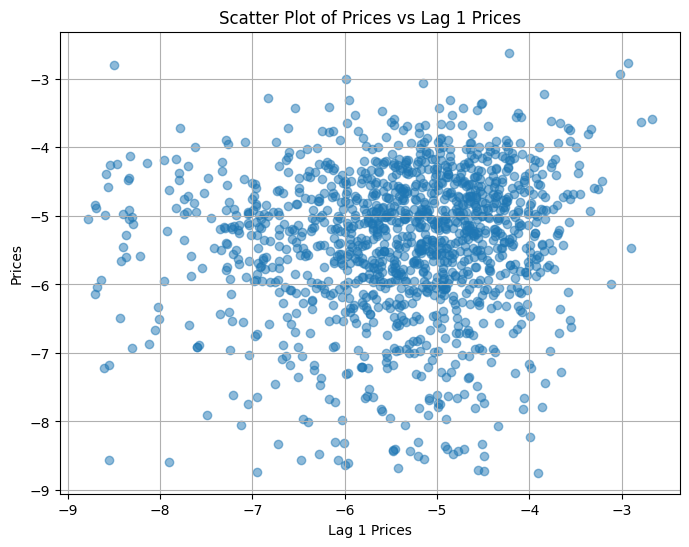

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example data series (replace this with your actual data)
data_series = np.log(RewardVector['Stock_1_Close'])

# Compute lag 1 prices
lag1_prices = data_series.shift(1)

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(lag1_prices, data_series, alpha=0.5)
plt.xlabel('Lag 1 Prices')
plt.ylabel('Prices')
plt.title('Scatter Plot of Prices vs Lag 1 Prices')
plt.grid(True)
plt.show()


In [ ]:
def tangency_weights(covariance_matrix, mean_vector):
    n = len(mean_vector)
    
    # Objective function to maximize (Sharpe ratio)
    def objective_function(weights):
        portfolio_return = np.dot(weights, mean_vector)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
        return -portfolio_return / portfolio_std
    
    # Constraint: sum of weights equals 1
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    
    # Bounds for each weight (0 <= weight <= 1)
    bounds = tuple((0, 1) for _ in range(n))
    
    # Initial guess for weights
    initial_guess = np.ones(n) / n
    
    # Optimization
    result = minimize(objective_function, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    
    # Extracting optimal weights
    optimal_weights = result.x
    
    # Calculate the mean and standard deviation of the tangency portfolio
    tangency_return = np.dot(optimal_weights, mean_vector)
    tangency_std = np.sqrt(np.dot(optimal_weights.T, np.dot(covariance_matrix, optimal_weights)))
    
    return {
        'weights': optimal_weights,
        'mean': tangency_return,
        'std': tangency_std,
        'maximized_value': -result.fun  # Negative because we minimized the negative of Sharpe ratio
    }

# Example usage:
result = tangency_weights(RewardVector.iloc[:2529].cov(), RewardVector.iloc[:2529].mean())
print("Optimal Weights:", result['weights'])
print("Tangency Portfolio Mean:", result['mean']*100)
print("Tangency Portfolio Standard Deviation:", result['std'])
print("Maximized Value:", result['maximized_value'])

Optimal Weights: [0.13250862 0.86749138]
Tangency Portfolio Mean: 0.02035972742490487
Tangency Portfolio Standard Deviation: 0.009711523441598315
Maximized Value: 0.02096450422772607


In [ ]:
def estimate_covariance(RewardVector):
    num_stocks = len(RewardVector.columns)
    num_rows = len(RewardVector)
    
    covariance_estimates = []
    
    for i in range(1, num_rows + 1):
        # Select the data for the current window up to the ith row
        window_data = RewardVector.iloc[:i]
        
        # Calculate the covariance matrix for the current window
        covariance_matrix = window_data.cov()
        
        # Extract variances and covariance from the covariance matrix
        variances = covariance_matrix.values.diagonal()
        covariance = covariance_matrix.values[np.triu_indices_from(covariance_matrix, k=1)]
        
        # Append variances and covariance to the list
        covariance_estimates.append(np.concatenate([variances, covariance]))
    
    # Create a DataFrame with the estimates
    columns = [f'Stock_{i}_Variance' for i in range(1, num_stocks + 1)] + \
              [f'Stock_{i}_Covariance' for i in range(1, num_stocks) for j in range(i+1, num_stocks + 1)]
    
    covariance_df = pd.DataFrame(covariance_estimates, columns=columns)
    
    return covariance_df
covariance = estimate_covariance(RewardVector)

c:\Users\20213931\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\frame.py:11198: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
c:\Users\20213931\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\20213931\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [ ]:
# Concatenate the two DataFrames along axis 1 (columns)
df = pd.concat([InputStates, covariance], axis=1)

# Optional: Reset the index of the concatenated DataFrame
df.reset_index(drop=True, inplace=True)
df

,Stock_1_Open_0,Stock_1_Open_1,Stock_1_Open_2,Stock_1_Open_3,Stock_1_Open_4,Stock_1_High_0,Stock_1_High_1,Stock_1_High_2,Stock_1_High_3,Stock_1_High_4,...,Stock_2_Low_3,Stock_2_Low_4,Stock_2_Close_0,Stock_2_Close_1,Stock_2_Close_2,Stock_2_Close_3,Stock_2_Close_4,Stock_1_Variance,Stock_2_Variance,Stock_1_Covariance
0,1.023661,1.008995,1.003520,1.016425,1.003129,1.024638,1.015643,1.010950,1.016425,1.004693,...,0.994119,0.995957,1.000368,1.004411,1.003492,0.996692,1.0,NaN,NaN,NaN
1,1.007026,1.001561,1.014442,1.001171,0.998048,1.013661,1.008977,1.014442,1.002732,1.002147,...,1.005567,0.998701,1.014103,1.013175,1.006309,1.009649,1.0,0.000022,0.000007,-0.000012
2,1.006275,1.019216,1.005882,1.002745,1.002941,1.013725,1.019216,1.007451,1.006863,1.007451,...,1.004667,0.999813,1.019227,1.012320,1.015680,1.005973,1.0,0.000011,0.000006,-0.000006
3,1.020416,1.007067,1.003926,1.004123,0.990381,1.020416,1.008638,1.008049,1.008638,1.000589,...,1.004878,0.999062,1.017448,1.020826,1.011069,1.005066,1.0,0.000035,0.000005,-0.000010
4,1.019070,1.015892,1.016091,1.002185,1.004172,1.020660,1.020064,1.020660,1.012515,1.015097,...,1.003770,0.995099,1.025636,1.015834,1.009802,1.004713,1.0,0.000037,0.000154,-0.000047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5044,1.028725,1.016966,1.014111,1.013775,1.006215,1.029229,1.020998,1.016126,1.018646,1.006215,...,0.992721,0.993647,0.991796,0.992968,0.996484,0.995436,1.0,0.000133,0.000116,0.000064
5045,1.012205,1.009363,1.009029,1.001505,0.990303,1.016218,1.011369,1.013877,1.001505,1.002341,...,1.007820,0.990178,1.007132,1.010698,1.009635,1.014264,1.0,0.000133,0.000116,0.000064
5046,1.014281,1.013945,1.006384,0.995128,1.006552,1.016297,1.018817,1.006384,1.007224,1.009913,...,0.989373,0.995187,1.009877,1.008814,1.013440,0.999187,1.0,0.000133,0.000116,0.000064
5047,1.013434,1.005877,0.994626,1.006045,0.999496,1.018304,1.005877,1.006717,1.009404,1.007557,...,0.999121,0.999247,1.012803,1.017447,1.003138,1.003954,1.0,0.000133,0.000116,0.000064


In [ ]:
class ContextualBandit():
    
    def __init__(self, state_dim, action_dim, sigma, gamma=0.9, alpha=0.01, epsilon=1, decay=0.9999, decaya=0.9):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.model = self.build_model()
        self.sigma = sigma
        self.eps =epsilon
        self.decay = decay
        self.decaya = decaya
        
    
    def build_model(self):
        model = Sequential([
            Dense(64, activation='relu', input_shape=(self.state_dim,)),
            Dense(64, activation='relu'),
            Dense(self.action_dim, activation='softmax')
        ])
        model.compile(loss='mse', optimizer=Adam(lr=self.alpha))
        return model
    
    def update_q_values(self, state, action_probs, reward, next_state):
        state = state.to_numpy().reshape(1, -1)  # Convert state to NumPy array
        next_state = next_state.to_numpy().reshape(1, -1)  # Convert next_state to NumPy array
        target = reward + self.gamma * np.max(self.model.predict(next_state))
        target_full = self.model.predict(state)
        for i in range(self.action_dim):
            target_full[0][i] = action_probs[i] * target  # Update each action value with the scaled target
        self.model.fit(state, target_full, epochs=1, verbose=0)



    def CreateWeightsVector(self, action):
        #print(np.sum(action))
        if np.sum(action) >0 : #we can not invest, this is denoted by the action being the zero vector
            return action/ np.sum(action)
        else:
            return action
    def GetReward(self , action, reward ,cov):
        #print(action)
        weights = self.CreateWeightsVector(action)
        #print(np.sum(weights), (action))
        if (np.sum(weights)) == 0:
            return 0 # no change in capital, if the timeframe is large enough maybe we want to decrease it by a bit because of inflation
        else:
            return (np.sum(reward * np.array(weights))+0.1)* 10000000* int(self.sigma > np.sqrt(np.dot(weights.T, np.dot(cov, weights))))- 10000000* int(self.sigma < np.sqrt(np.dot(weights.T, np.dot(cov, weights))))
            

    def select_action(self, state, bool = True):
        if self.eps > np.random.random() and bool:
            self.eps*= self.decay
            return np.random.dirichlet(np.ones(self.action_dim))
        else: 
            state = state.to_numpy().reshape(1, -1)  # Convert pandas Series to NumPy array
            action_probs = self.model.predict(state)[0]  # Get action probabilities from the model
            print(action_probs)
            self.alpha *= self.decaya
            
            return action_probs


In [ ]:
class ContextualBandit():
    
    def __init__(self, state_dim, action_dim, sigma, gamma=0.9, alpha=0.01, epsilon=1, decay=0.9999, decaya=0.9):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.model = self.build_model()
        self.sigma = sigma
        self.eps =epsilon
        self.decay = decay
        self.decaya = decaya
        

    def build_model(self):
        model = Sequential([
            Dense(64, activation='relu', input_shape=(self.state_dim,)),
            Dense(64, activation='relu'),
            Dense(self.action_dim, activation='softmax')
        ])
        model.compile(loss='mse', optimizer=Adam(lr=self.alpha))
        return model
    
    def update_q_values(self, state, action_probs, reward, next_state):
        state = state.to_numpy().reshape(1, -1)  # Convert state to NumPy array
        next_state = next_state.to_numpy().reshape(1, -1)  # Convert next_state to NumPy array
        target = reward + self.gamma * np.max(self.model.predict(next_state))
        target_full = self.model.predict(state)
        for i in range(self.action_dim):
            target_full[0][i] = action_probs[i] * target  # Update each action value with the scaled target
        self.model.fit(state, target_full, epochs=1, verbose=0)



    def CreateWeightsVector(self, action):
        #print(np.sum(action))
        if np.sum(action) >0 : #we can not invest, this is denoted by the action being the zero vector
            return action/ np.sum(action)
        else:
            return action
    def GetReward(self , action, reward ,cov):
        #print(action)
        weights = self.CreateWeightsVector(action)
        #print(np.sum(weights), (action))
        if (np.sum(weights)) == 0:
            return 0 # no change in capital, if the timeframe is large enough maybe we want to decrease it by a bit because of inflation
        else:
            return np.sum(reward * np.array(weights))* 10000000* int(self.sigma > np.sqrt(np.dot(weights.T, np.dot(cov, weights))))- 10000000* int(self.sigma < np.sqrt(np.dot(weights.T, np.dot(cov, weights))))
            

    def select_action(self, state, bool = True):
        if self.eps > np.random.random() and bool:
            self.eps*= self.decay
            return np.random.dirichlet(np.ones(self.action_dim))
        else: 
            state = state.to_numpy().reshape(1, -1)  # Convert pandas Series to NumPy array
            action_probs = self.model.predict(state)[0]  # Get action probabilities from the model
            print(action_probs)
            self.alpha *= self.decaya
            
            return action_probs

In [ ]:
state_dim = df.shape[1]
action_dim = RewardVector.shape[1] 
bandit = ContextualBandit(state_dim, action_dim, sigma=result['std'])
action_dim

2

In [ ]:
model_path = "RealData.pkl"  # Fixed file path for the model

# Training loop
for j in range(1):
    for i in range(504, len(RewardVector) - 504):
        # Your code to select state and take actions
        state = df.iloc[i]
        action = np.array(bandit.select_action(state))
        
        reward = bandit.GetReward(action, RewardVector.iloc[i], RewardVector.iloc[:i].cov())
        print(reward)
        next_state = df.iloc[i + 1]
        bandit.update_q_values(state, action, reward, next_state)
        
        # Check if the current iteration is a multiple of 1000
        if (i + 1) % 504 == 0:
            # Save the model
            with open(model_path, 'wb') as f:
                pickle.dump(bandit, f)
            print(f"Model saved at iteration {i+1} as {model_path}")

# After the loop completes, save the model once more
with open(model_path, 'wb') as f:
    pickle.dump(bandit, f)
print(f"Final model saved as {model_path}")

24851.540841047627
1/1 [==============================] - 0s 18ms/step



47941.6025580982
1/1 [==============================] - 0s 17ms/step
12847.435707349976
1/1 [==============================] - 0s 17ms/step
18212.781654165654
1/1 [==============================] - 0s 17ms/step
-33105.40075281522
1/1 [==============================] - 0s 18ms/step
-38824.728063098984
1/1 [==============================] - 0s 18ms/step
43109.118423766064
1/1 [==============================] - 0s 17ms/step
-112106.84119521231
1/1 [==============================] - 0s 16ms/step
13027.699450768521
1/1 [==============================] - 0s 16ms/step
-63177.812492542114
1/1 [==============================] - 0s 17ms/step
-32171.518975892788
1/1 [==============================] - 0s 16ms/step
41345.706025523
1/1 [==============================] - 0s 17ms/step
49873.61706929207
1/1 [==============================] - 0s 17ms/step
100684.15331181412
1/1 [==============================] - 0s 17ms/step
-21598.726081907735
1/1 [==============================] - 0s 16ms/step
94598.4

In [ ]:
model_path = "RealData.pkl"  # Fixed file path for the model

# Load the saved model
with open(model_path, 'rb') as f:
    bandit = pickle.load(f)

# Continue training loop
for j in range(1):
    for i in range(504, len(RewardVector) - 504):
        # Your code to select state and take actions
        state = df.iloc[i]
        action = np.array(bandit.select_action(state))
        
        reward = bandit.GetReward(action, RewardVector.iloc[i], RewardVector.iloc[:i].cov())
        print(reward)
        next_state = df.iloc[i + 1]
        bandit.update_q_values(state, action, reward, next_state)
        
        # Check if the current iteration is a multiple of 1000
        if (i + 1) % 504 == 0:
            # Save the model
            with open(model_path, 'wb') as f:
                pickle.dump(bandit, f)
            print(f"Model saved at iteration {i+1} as {model_path}")

# After the loop completes, save the final model
with open(model_path, 'wb') as f:
    pickle.dump(bandit, f)
print(f"Final model saved as {model_path}")

38292.07084859294
1/1 [==============================] - 0s 16ms/step
[0.468279 0.531721]
30572.419391721993
1/1 [==============================] - 0s 18ms/step
14083.441587916504
1/1 [==============================] - 0s 17ms/step
[0.4646773 0.5353227]
15502.106036035799
1/1 [==============================] - 0s 17ms/step
-32645.303949698457
1/1 [==============================] - 0s 17ms/step
-35016.86491884418
1/1 [==============================] - 0s 17ms/step
64159.414744232294
1/1 [==============================] - 0s 17ms/step
-111161.79785305506
1/1 [==============================] - 0s 16ms/step
[0.45858073 0.5414193 ]
37938.94781274495
1/1 [==============================] - 0s 16ms/step
3580.4725189833707
1/1 [==============================] - 0s 19ms/step
-29675.67540850256
1/1 [==============================] - 0s 16ms/step
59229.73887921163
1/1 [==============================] - 0s 17ms/step
17489.282375171693
1/1 [==============================] - 0s 16ms/step
92876.693753

In [ ]:
model_path = "RealData.pkl"  # Change the path to the location of your saved model file
with open(model_path, 'rb') as f:
    loaded_bandit = pickle.load(f)

In [ ]:
# Initialize lists to store actions and rewards
test_actions = []
test_rewards = []
test_rewards_model = []
test_rewards_tan = []
# Testing loop
for i in range(len(RewardVector)-500, len(RewardVector)):
    # Select state and take action using the loaded bandit model
    state = df.iloc[i]
    action = np.array(loaded_bandit.select_action(state, bool = False))
    test_actions.append(action)
    
    # Get reward from the environment
    reward = loaded_bandit.GetReward(action, RewardVector.iloc[i], RewardVector.iloc[:i].cov())
    test_rewards.append(reward)
    test_rewards_model.append(np.sum(RewardVector.iloc[i] * np.array(action)))
    test_rewards_tan.append(np.sum(RewardVector.iloc[i] * np.array(result['weights'])))
# Print the actions and rewards obtained during testing
print("Actions taken during testing:", test_actions)
print("Rewards obtained during testing:", test_rewards)

1/1 [==============================] - 0s 45ms/step
[0.54172146 0.4582785 ]
1/1 [==============================] - 0s 17ms/step
[0.5411367  0.45886335]
1/1 [==============================] - 0s 16ms/step
[0.54044294 0.45955706]
1/1 [==============================] - 0s 17ms/step
[0.5413392  0.45866075]
1/1 [==============================] - 0s 17ms/step
[0.54081035 0.45918962]
1/1 [==============================] - 0s 18ms/step
[0.54138345 0.45861658]
1/1 [==============================] - 0s 17ms/step
[0.54124504 0.45875487]
1/1 [==============================] - 0s 17ms/step
[0.54148304 0.45851696]
1/1 [==============================] - 0s 16ms/step
[0.541902   0.45809796]
1/1 [==============================] - 0s 16ms/step
[0.54125637 0.4587436 ]
1/1 [==============================] - 0s 18ms/step
[0.54105294 0.458947  ]
1/1 [==============================] - 0s 17ms/step
[0.541063   0.45893702]
1/1 [==============================] - 0s 17ms/step
[0.54117167 0.45882827]
1/1 [=======

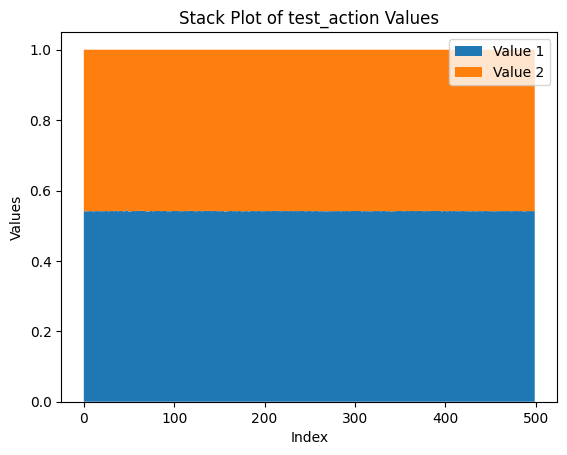

In [ ]:
# Transpose the values to have them in the correct format for plotting
test_action_transposed = list(zip(*test_actions))

# Create the stack plot
plt.stackplot(range(len(test_action_transposed[0])), test_action_transposed[0], test_action_transposed[1], labels=['Value 1', 'Value 2'])
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Stack Plot of test_action Values')
plt.legend()
plt.show() 


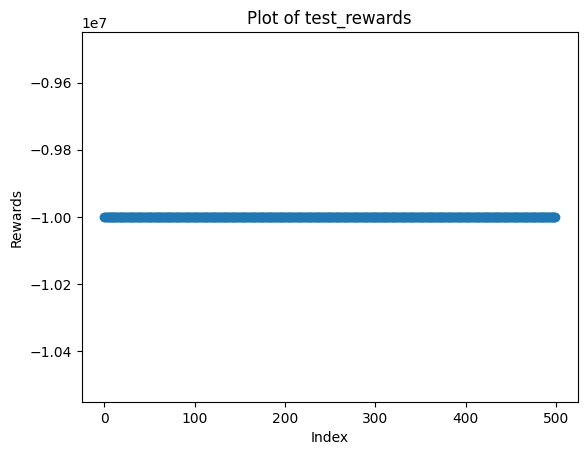

In [ ]:
# Create a separate plot for test_rewards
plt.plot(range(len(test_rewards)), test_rewards, marker='o')
plt.xlabel('Index')
plt.ylabel('Rewards')
plt.title('Plot of test_rewards')
plt.show()

In [ ]:
test_rewards_tan = np.array(test_rewards_tan)+1
test_rewards_tan = np.cumprod(test_rewards_tan)
test_rewards_model = np.array(test_rewards_model)+1
test_rewards_model = np.cumprod(test_rewards_model)


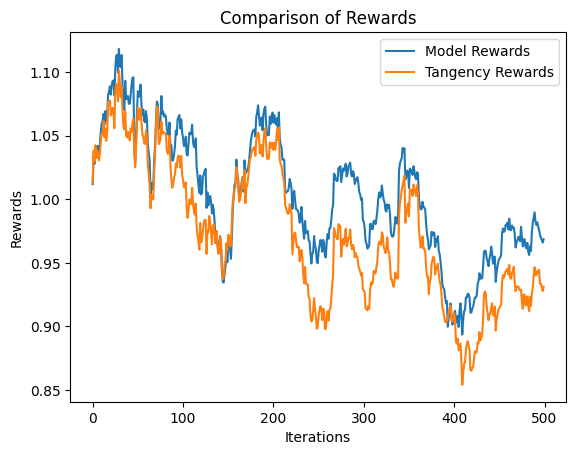

In [ ]:
# Plot the rewards for the model
plt.plot(test_rewards_model, label='Model Rewards')

# Plot the rewards for the tan
plt.plot(test_rewards_tan, label='Tangency Rewards')

# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Rewards')
plt.title('Comparison of Rewards')
plt.legend()  # Show legend with labels

# Show the plot
plt.show()